<a href="https://colab.research.google.com/github/sungkim11/forecast-sales/blob/main/forecast_sales_using_numpyro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecast Sales with NumPyro

NumPyro is probabilistic programming with NumPy powered by JAX for autograd and JIT compilation to GPU/TPU/CPU.

## 1. Prequisites

Following are prerequisite for this tutorial:

- Data
- Python Package: NumPyro
- Python Package: Jax
- Python Package: Statsmodels

### 1.1. Data

Three data sources were used for this tutorial where United Stated Census Bureau Monthly Retail Sales is used to forecast future sales and both FRED Data and OECD Data were used as Regressors data.

**United Stated Census Bureau Monthly Retail Sales**
United Stated Census Bureau maintains Monthly Retail Trade Report, from January 1992 to Present. This data was picked to illustrate forecasting because it has extensive historical data with same monthly frequency. Data is available as Excel spreadsheet format at https://www.census.gov/retail/mrts/www/mrtssales92-present.xls

**FRED Data: https://fred.stlouisfed.org/**

- Inflation
- CPI
- M1
- M2
- Interest Rate

**OECD Data: https://data.oecd.org/leadind/composite-leading-indicator-cli.htm#indicator-chart**

- Composite leading indicator (CLI)
- Business confidence index (BCI)
- Consumer confidence index (CCI)

## 1.2. Python Packages

#### 1.2.1. Install Python Packages

In [1]:
%%writefile requirements.txt

pandas==1.3.5
matplotlib==3.2.2
jax==0.3.8
numpyro==0.9.2
statsmodels==0.10.2

Writing requirements.txt


In [2]:
!pip install -r requirements.txt

     |████████████████████████████████| 283 kB 10.6 MB/s 


## 2. Code

### 2.1. Import Python Package

Import python packages and show its version. Showing version is important since it will enable other users to replicate your work using same python version and python packages version.

In [3]:
import os
import platform

import matplotlib
from matplotlib import pyplot as plt

import pandas as pd
from IPython.display import set_matplotlib_formats

import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

import jax
from jax import numpy as jnp
from jax import random

import numpyro
from numpyro import distributions as dist
from numpyro.contrib.control_flow import scan
from numpyro.diagnostics import autocorrelation, hpdi
from numpyro.infer import MCMC, NUTS, Predictive

if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats("svg")

numpyro.set_host_device_count(8)


print('Python: ', platform.python_version())
print('pandas: ', pd.__version__)
print('matplotlib: ', matplotlib.__version__)
print('Jax: ', jax.__version__)
print('NumPyro: ', numpyro.__version__)
print('statsmodels: ', statsmodels.__version__)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Python:  3.7.13
pandas:  1.3.5
matplotlib:  3.2.2
Jax:  0.3.8
NumPyro:  0.9.2
statsmodels:  0.10.2


### 2.2. Mount Storage

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2.3. Prep Data

#### Import and validate dataset

In [5]:
retail_sales = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/forecast-sales/data/mrtssales92-present.csv', index_col = None)
retail_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   month        205 non-null    object
 1   sales_total  205 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.3+ KB


#### Resize dataset

We will ONLY be using retail sales data from 01/01/2005 thru 12/31/2018.

In [6]:
retail_sales = retail_sales[:-37]
retail_sales.info()
retail_sales.tail(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   month        168 non-null    object
 1   sales_total  168 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.8+ KB


,month,sales_total
163,8/1/2018,520544
164,9/1/2018,477137
165,10/1/2018,503602
166,11/1/2018,518457
167,12/1/2018,556614


#### Convert 'month' column to datetime column.

In [7]:
retail_sales['month'] = pd.to_datetime(retail_sales.month)
retail_sales.head(5)

,month,sales_total
0,2005-01-01,293261
1,2005-02-01,295062
2,2005-03-01,339141
3,2005-04-01,335632
4,2005-05-01,345348


#### Split datasets for Exploratory Data Analysis
- Train
- Test

In [8]:
retail_sales_train = retail_sales[:-24]
retail_sales_test = retail_sales[-24:]

print('Train: ', retail_sales_train.shape)
print('Test: ', retail_sales_test.shape)

Train:  (144, 2)
Test:  (24, 2)


### 2.4. Exploratory Data Analysis

#### Set Plotting Parameters

In [9]:
# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Set figure width to 12 and height to 9
fig_size[0] = 30
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

#### Chart Retail Sales

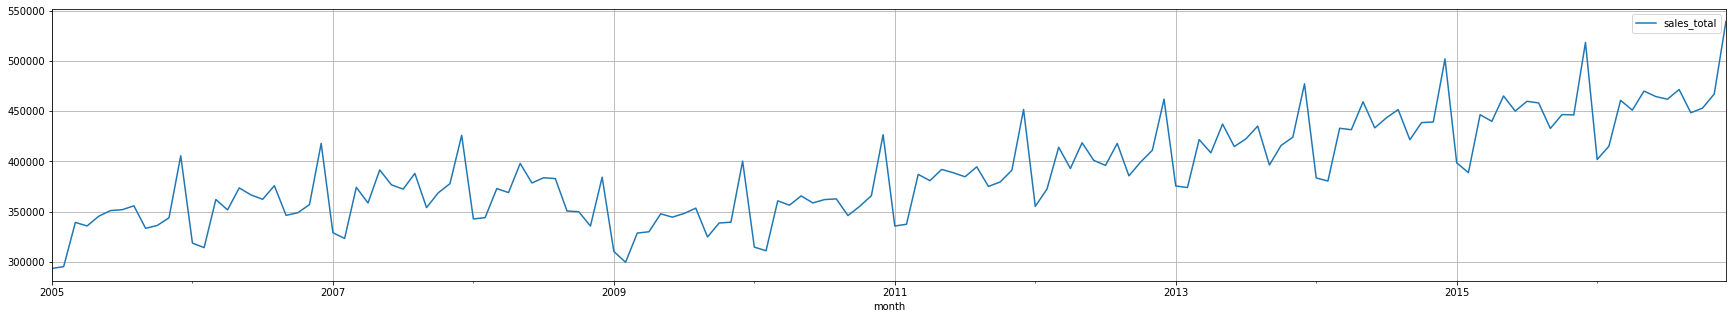

In [10]:
retail_sales_train.plot(x='month', y='sales_total', kind='line', grid=1)
plt.show()

#### Determine Retail Sales Data (Time-Series) has trend

Next, we need to determine if the retail sales data is non-stationary or it has trends using Dickey Fuller Test, which is a statistical hypothesis test that allows you to detect non-stationarity. The stationary time-series implies there is no predictable pattern in the long term.

In [11]:
from statsmodels.tsa.stattools import adfuller
adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(retail_sales_train.sales_total.values)
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: -0.41114662261582896
ADF p-values: 0.9082209893408628
ADF number of lags used: 14
ADF number of observations: 129
ADF critical values: {'1%': -3.482087964046026, '5%': -2.8842185101614626, '10%': -2.578864381347275}
ADF best information criterion: 2712.938864098956


Looking at the value, which is bigger than 0.05, you can determine time-series data is non-stationary.

### 2.5. Prep Data for Modeling

For NumPyro, we will only need "sales_total" since data/time is not included for forecasting.

In [12]:
retail_sales_data = retail_sales["sales_total"].values
print("Length of time series:", retail_sales.shape[0])

Length of time series: 168


In [ ]:
#plt.figure(figsize=(20, 5))
#plt.plot(retail_sales["month"], retail_sales_data)
#plt.show()

Split dataset to train and test then convert the dataframe to Jax Numpy array.

In [13]:
y_train, y_test = jnp.array(retail_sales_data[:144], dtype=jnp.float32), retail_sales_data[144:]
y_train.shape, y_test.shape

((144,), (24,))

In [14]:
y_train

DeviceArray([293261., 295062., 339141., 335632., 345348., 350945.,
             351827., 355701., 333289., 336134., 343798., 405608.,
             318546., 314051., 361993., 351667., 373560., 366615.,
             362203., 375795., 346214., 348796., 356928., 417991.,
             328877., 323162., 374142., 358535., 391512., 376639.,
             372354., 388016., 353936., 368681., 377802., 426077.,
             342639., 343893., 372907., 368920., 397956., 378507.,
             383726., 382862., 350542., 349847., 335545., 384236.,
             310188., 299412., 328526., 329854., 347728., 344405.,
             348071., 353392., 324646., 338610., 339363., 400281.,
             314557., 310925., 360679., 356333., 365605., 358604.,
             361939., 362627., 345999., 355209., 365828., 426663.,
             335587., 337314., 387088., 380775., 391999., 388700.,
             384682., 394609., 375025., 379482., 391220., 451821.,
             355184., 372401., 414149., 392949., 418608., 4009

In [15]:
y_test

array([421943, 418315, 483082, 465788, 494621, 481729, 475374, 490324,
       469710, 476014, 497748, 558215, 444286, 435373, 508383, 480373,
       527991, 507106, 505209, 520544, 477137, 503602, 518457, 556614])

### 2.6. Develop Forecast Model

#### Define model

Seasonal, Global Trend (SGT) model is copied from NumPyro website => https://num.pyro.ai/en/stable/tutorials/time_series_forecasting.html

In [18]:
def sgt(y, seasonality, future=0):
    # heuristically, standard derivation of Cauchy prior depends on
    # the max value of data
    cauchy_sd = jnp.max(y) / 150

    # NB: priors' parameters are taken from
    # https://github.com/cbergmeir/Rlgt/blob/master/Rlgt/R/rlgtcontrol.R
    nu = numpyro.sample("nu", dist.Uniform(2, 20))
    powx = numpyro.sample("powx", dist.Uniform(0, 1))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(cauchy_sd))
    offset_sigma = numpyro.sample(
        "offset_sigma", dist.TruncatedCauchy(low=1e-10, loc=1e-10, scale=cauchy_sd)
    )

    coef_trend = numpyro.sample("coef_trend", dist.Cauchy(0, cauchy_sd))
    pow_trend_beta = numpyro.sample("pow_trend_beta", dist.Beta(1, 1))
    # pow_trend takes values from -0.5 to 1
    pow_trend = 1.5 * pow_trend_beta - 0.5
    pow_season = numpyro.sample("pow_season", dist.Beta(1, 1))

    level_sm = numpyro.sample("level_sm", dist.Beta(1, 2))
    s_sm = numpyro.sample("s_sm", dist.Uniform(0, 1))
    init_s = numpyro.sample("init_s", dist.Cauchy(0, y[:seasonality] * 0.3))

    def transition_fn(carry, t):
        level, s, moving_sum = carry
        season = s[0] * level**pow_season
        exp_val = level + coef_trend * level**pow_trend + season
        exp_val = jnp.clip(exp_val, a_min=0)
        # use expected vale when forecasting
        y_t = jnp.where(t >= N, exp_val, y[t])

        moving_sum = (
            moving_sum + y[t] - jnp.where(t >= seasonality, y[t - seasonality], 0.0)
        )
        level_p = jnp.where(t >= seasonality, moving_sum / seasonality, y_t - season)
        level = level_sm * level_p + (1 - level_sm) * level
        level = jnp.clip(level, a_min=0)

        new_s = (s_sm * (y_t - level) / season + (1 - s_sm)) * s[0]
        # repeat s when forecasting
        new_s = jnp.where(t >= N, s[0], new_s)
        s = jnp.concatenate([s[1:], new_s[None]], axis=0)

        omega = sigma * exp_val**powx + offset_sigma
        y_ = numpyro.sample("y", dist.StudentT(nu, exp_val, omega))

        return (level, s, moving_sum), y_

    N = y.shape[0]
    level_init = y[0]
    s_init = jnp.concatenate([init_s[1:], init_s[:1]], axis=0)
    moving_sum = level_init
    with numpyro.handlers.condition(data={"y": y[1:]}):
        _, ys = scan(
            transition_fn, (level_init, s_init, moving_sum), jnp.arange(1, N + future)
        )
    if future > 0:
        numpyro.deterministic("y_forecast", ys[-future:])

Choose a good value for seasonality. I used seasonality = 60, but there must be a better way to determine this number.

In [16]:
print("Lag values sorted according to their autocorrelation values:\n")
print(jnp.argsort(autocorrelation(y_train))[::-1])

Lag values sorted according to their autocorrelation values:

[  0  12   5   1   4   7   3  24   8   2   6   9  11  17  13  16  19  36
  10  15  14  20  18  21  23  48  29  25  28  31  22  27  26  32  30  33
  41  40  43  35  37  39  44  34  42  38  45  60  47  49  46  52  53  51
  55  50  54  56  57  72  59  58  61  65  64  96  63  84  67  62  66  68
 108  69  71  77  76  73  70  79  75 101 100  80  89  74 103  78  91  88
  97  99  81  83  95  92 102  85  87  93  90  98 104 120  86  82 105  94
 107 109 106 112 113 111 110 115 114 116 117 132 119 121 124 118 123 125
 122 127 126 128 129 131 133 130 134 136 135 137 138 139 140 141 142 143]


#### Train model

Please play with different numbers to obtain best performance.

In [34]:
%%time
kernel = NUTS(sgt)
mcmc = MCMC(kernel, num_warmup=5000, num_samples=5000, num_chains=2)
mcmc.run(random.PRNGKey(0), y_train, seasonality=60)
mcmc.print_summary()
samples = mcmc.get_samples()

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
      coef_trend  12926.60  32879.82   4290.40    430.55  25116.68    419.20      1.01
       init_s[0]  11332.11  10102.36  11844.45  -3934.94  25927.21   1534.14      1.00
       init_s[1]  -9946.26  10418.48  -9306.38 -24772.83   4429.24   2756.61      1.00
       init_s[2]  30041.11  12943.60  31360.71  16694.78  46954.26    824.94      1.00
       init_s[3]  20422.90  37279.10  27374.57   7928.28  50533.45    108.59      1.02
       init_s[4]  19287.04  51993.78  34807.20  -7492.88  58370.48    239.78      1.01
       init_s[5] -103690.29  94060.34 -127945.58 -215036.39  49156.58    214.33      1.01
       init_s[6]   9668.70  54390.01  27314.97 -62886.11  56876.00    198.86      1.01
       init_s[7]  21940.93  35280.89  29969.52   2876.12  51406.94    385.59      1.01
       init_s[8]   7680.70  13813.34   8967.25  -6892.89  24473.25    599.17      1.00
       init_s[9]  11481.58   9899.00  1

#### Predict Retail Sales with model

In [35]:
predictive = Predictive(sgt, samples, return_sites=["y_forecast"])
forecast_marginal = predictive(random.PRNGKey(1), y_train, seasonality=60, future=24)[
    "y_forecast"
]

### 2.7. Validate Forecast Model Using NumPyro

In [41]:
y_pred = jnp.mean(forecast_marginal, axis=0)
y_pred

DeviceArray([432648.22, 450141.03, 492334.6 , 471545.7 , 497817.62,
             480987.53, 476760.3 , 499753.97, 467696.94, 482233.44,
             494952.22, 546892.6 , 461033.72, 460759.34, 510162.  ,
             497517.16, 527354.6 , 506190.38, 514950.34, 528746.75,
             491016.44, 512842.75, 521375.53, 575445.  ], dtype=float32)

Calculate both smape and rmse.

In [43]:
sMAPE = jnp.mean(jnp.abs(y_pred - y_test) / (y_pred + y_test)) * 200
msqrt = jnp.sqrt(jnp.mean((y_pred - y_test) ** 2))
print("sMAPE: {:.2f}, rmse: {:.2f}".format(sMAPE, msqrt))

sMAPE: 1.91, rmse: 12167.64


Finally, plot both actual retail sales and forecasted retail sales.

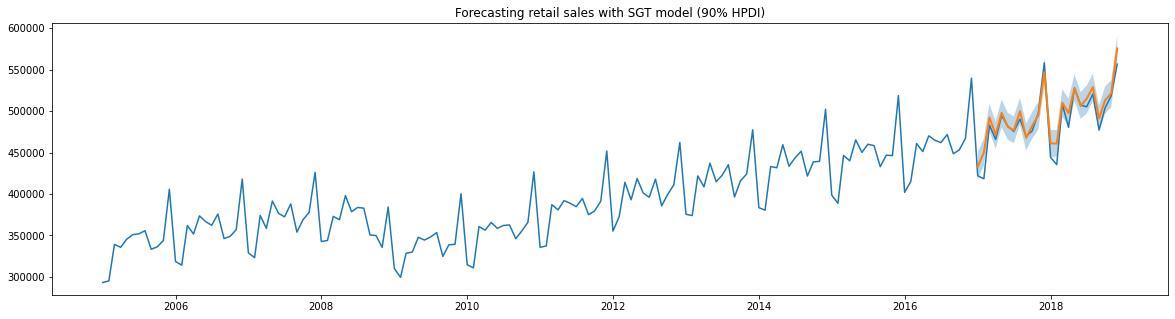

In [45]:
plt.figure(figsize=(20, 5))
plt.plot(retail_sales["month"], retail_sales_data)
t_future = retail_sales["month"][144:]
hpd_low, hpd_high = hpdi(forecast_marginal)
plt.plot(t_future, y_pred, lw=2)
plt.fill_between(t_future, hpd_low, hpd_high, alpha=0.3)
plt.title("Forecasting retail sales with SGT model (90% HPDI)")
plt.show()

### 2.8. Validate Forecast Model

In [62]:
y_pred_df = pd.DataFrame(y_pred, columns = ['prediction']).astype(int)
y_pred_df['numrow'] = range(1, len(y_pred_df) + 1)
retail_sales_test['numrow'] = range(1, len(retail_sales_test) + 1)
retail_sales_validate = retail_sales_test.merge(y_pred_df, on='numrow', how='left')
retail_sales_validate = retail_sales_validate.drop('numrow', 1)
retail_sales_validate.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


,month,sales_total,prediction
0,2017-01-01,421943,432648
1,2017-02-01,418315,450141
2,2017-03-01,483082,492334
3,2017-04-01,465788,471545
4,2017-05-01,494621,497817


In [64]:
retail_sales_validate['AE'] = (retail_sales_validate['sales_total'] - retail_sales_validate['prediction']).abs()
retail_sales_validate['APE'] = (retail_sales_validate['sales_total'] - retail_sales_validate['prediction']).abs()/retail_sales_validate['sales_total']
retail_sales_validate.loc['MAPE'] = pd.Series(retail_sales_validate['APE'].mean(), index = ['APE'])
retail_sales_validate.loc['Min APE'] = pd.Series(retail_sales_validate['APE'].min(), index = ['APE'])
retail_sales_validate.loc['Max APE'] = pd.Series(retail_sales_validate['APE'].max(), index = ['APE'])
retail_sales_validate.tail(3)

,month,sales_total,prediction,AE,APE
MAPE,NaT,NaN,NaN,NaN,0.019438
Min APE,NaT,NaN,NaN,NaN,0.001206
Max APE,NaT,NaN,NaN,NaN,0.076081
